# Disaster Tweet Prediction 

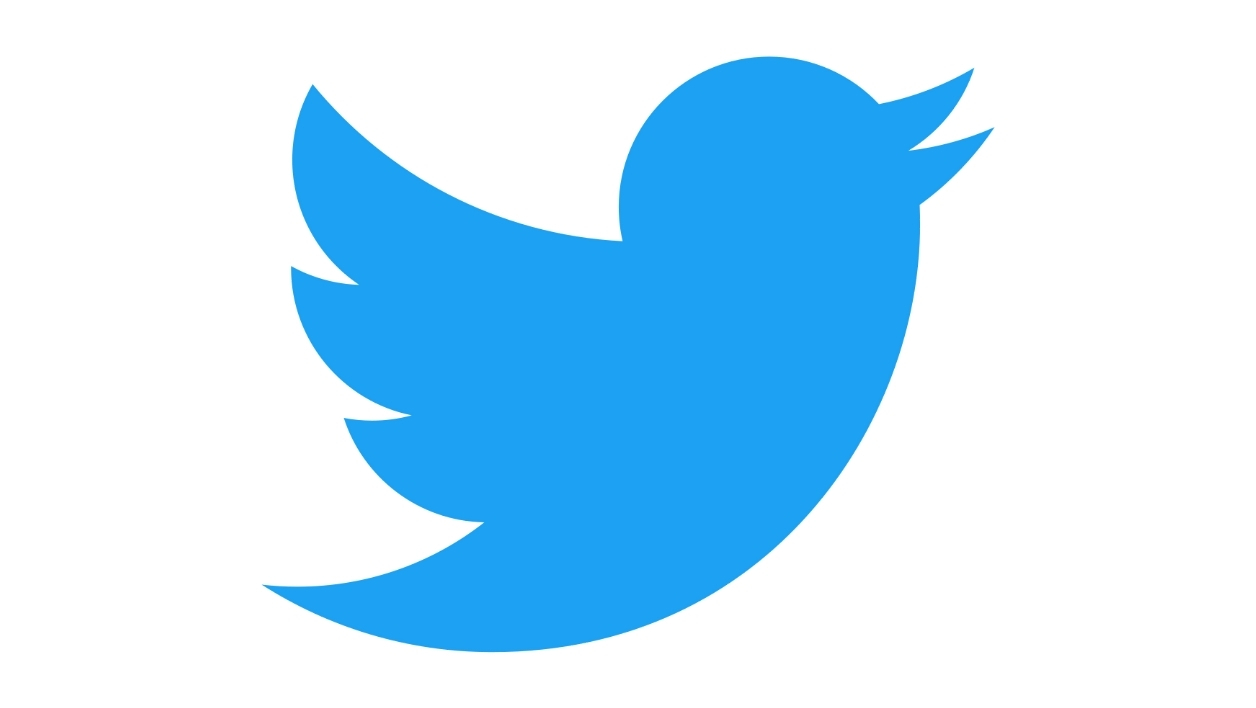

### Problem Statement

Twitter has become an important communication channel in times of emergency. The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programmatically monitoring Twitter (i.e. disaster relief organizations and news agencies). In this task, the goal is to predict whether a tweet is about a real disaster or not, where a real disaster will be represented as 1 and a non-disaster will be represented as 0. 

### Data Format 
Each sample of the train and test set has the following information: 
- The `text` of a tweet
- A `keyword` from the tweet (may have empty values)
- The `location` the tweet was sent from (may have empty values)
- Train set only will have the `target` 

### Workflow
Exploratory Data Analysis --> Preprocessing & Transformations --> Classification --> Evaluation

# Exploratory Data Analysis (EDA) 

In [1]:
import re
import string
import warnings
warnings.filterwarnings("ignore")

import nltk
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

import seaborn as sns
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import lightgbm as lgb
from keras.models import Model
import gensim.downloader as api
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Bidirectional
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers, Sequential

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer

Using TensorFlow backend.


In [2]:
# path/to/data
TRAIN_PATH = "../inputs/train.csv"
TEST_PATH = "../inputs/test.csv"

In [3]:
# read data
train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)

print(f"Train data shape: {train_df.shape}\nTest data shape: {test_df.shape}")

Train data shape: (7613, 5)
Test data shape: (3263, 4)


In [4]:
# more information about columns 
print(train_df.info())
print("\n-----------------------------------------\n")
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None

-----------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


In [5]:
# number of missing values per column in train 
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [6]:
# number of missing values per column in test
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [7]:
# checking if any id's from train are in test
train_df["id"].isin(test_df["id"]).value_counts()

False    7613
Name: id, dtype: int64

In [8]:
# number of text that's duplicated in train and test sets
train_df["text"].isin(test_df["text"]).value_counts()

False    7486
True      127
Name: text, dtype: int64

In [9]:
# appending the test data to train 
full_df = pd.concat(objs=[train_df, test_df], axis=0)
full_df.head() # train data would be above the test data

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0

In [10]:
# target should be NaN if concat performed correctly
full_df.tail()

id keyword location  \
3258  10861     NaN      NaN   
3259  10865     NaN      NaN   
3260  10868     NaN      NaN   
3261  10874     NaN      NaN   
3262  10875     NaN      NaN   

                                                   text  target  
3258  EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...     NaN  
3259  Storm in RI worse than last hurricane. My city...     NaN  
3260  Green Line derailment in Chicago http://t.co/U...     NaN  
3261  MEG issues Hazardous Weather Outlook (HWO) htt...     NaN  
3262  #CityofCalgary has activated its Municipal Eme...     NaN

### Class Counts

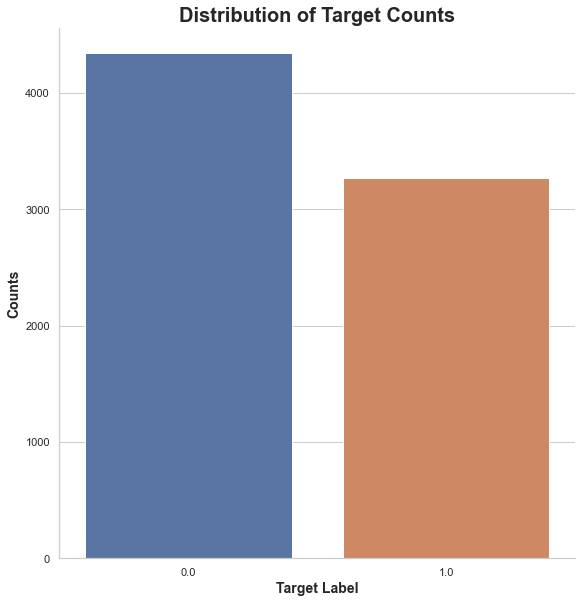

In [11]:
# counting the number of positive and negative tweets
sns.set(style="whitegrid", color_codes=True)
sns.catplot("target", data=full_df, kind="count", height=8)
plt.title("Distribution of Target Counts", size=20, weight="bold")
plt.xlabel("Target Label", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

In [12]:
# random examples of disaster tweets 
full_df[full_df["target"]==1].iloc[np.random.randint(0, 3000), -2] # will give new example after each run

'Watch how bad that fool get burned in coverage this year. Dat dude is all-pro practice squad material'

In [13]:
# random examples of non-disaster tweets 
full_df[full_df["target"]==0].iloc[np.random.randint(0, 4000), -2] # will give new example after each run

'New Explosion-proof Tempered Glass Screen Protector Film for Blackberry Z10 - Full read by\x89Û_ http://t.co/tOYU16mxBO http://t.co/P10hNDc0Mm'

### Percentage of missing values

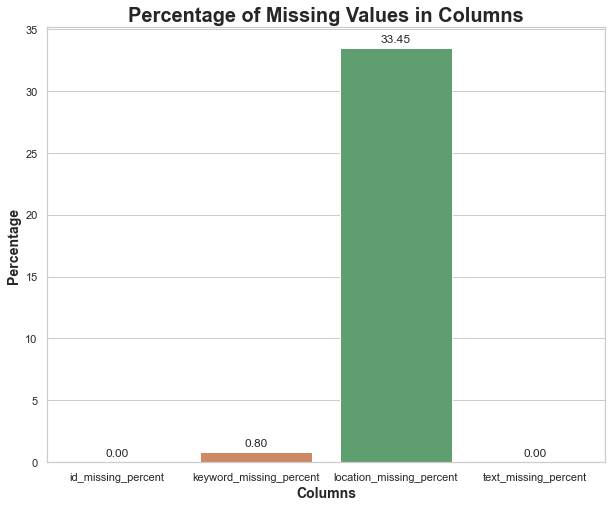

In [14]:
# creating a new dataframe for missing values percentage
missing_values = dict(zip([col+"_missing_percent" for col in full_df.columns if col != "target"],
                          [round(100*full_df[col].isnull().sum()/len(full_df), 2) for col in full_df.columns
                           if col != "target"]))
missing_values_df = pd.DataFrame(missing_values, index=[0])
missing_values_df = missing_values_df.melt(var_name= "columns", value_name= "percentage")

# plotting missing values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="percentage", data=missing_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Missing Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

### Unique Values Per Column

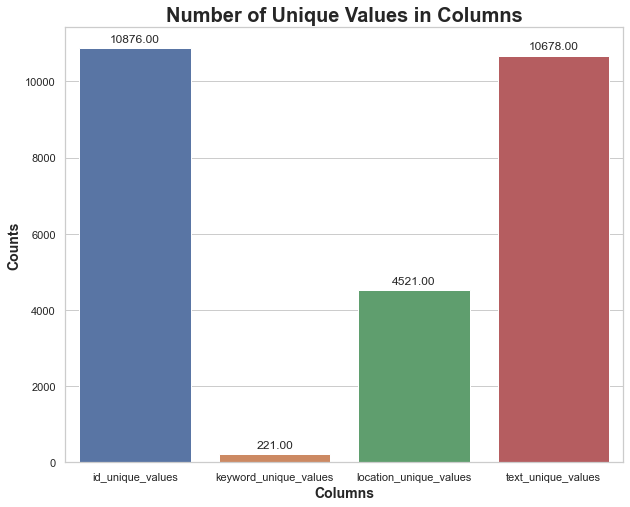

In [15]:
# creating a new dataframe for unique value cound
unique_values = dict(zip([col+"_unique_values" for col in full_df.columns if col != "target"],
                          [full_df[col].nunique() for col in full_df.columns if col != "target"]))
unique_values_df = pd.DataFrame(unique_values, index=[0])
unique_values_df = unique_values_df.melt(var_name= "columns", value_name= "counts")

# plotting unique values chart
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="columns", y="counts", data=unique_values_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Number of Unique Values in Columns", size=20, weight="bold")
plt.xlabel("Columns", size=14, weight="bold")
plt.ylabel("Counts", size=14, weight="bold")
plt.show()

**Note: 198 Tweets are not unique --> We have duplicates (Explore!)**

### Top Locations in Tweets

In [16]:
# creating a new dataframe with value counts of each location
locations= full_df["location"].value_counts().sort_values(ascending=False)
locations_df= pd.DataFrame(dict(zip(locations.index, locations.values)), index=[0]).\
                                melt(var_name="location", value_name="unique_counts")
locations_df.loc[:10]

location  unique_counts
0               USA            141
1          New York            109
2     United States             65
3            London             58
4            Canada             42
5           Nigeria             40
6         Worldwide             35
7             India             35
8   Los Angeles, CA             34
9                UK             33
10            Kenya             32

In [17]:
# plotting in a graph 
data = {
    "values": locations_df["unique_counts"].loc[:10],
    "labels": locations_df["location"].loc[:10],
    "domain": {"column": 0},
    "hoverinfo": "label + percent",
    "type": "pie"
}
layout = go.Layout(title= "<b>Top 10 Locations from Tweets</b>",
                   legend= dict(x=0.1, y=1.1, orientation="h"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

In [18]:
# replacing some names from locations to be all countries
replace_names= {
    "USA":"United States",
    "New York":"United States",
    "Los Angeles": "United States",
    "Los Angeles, CA":"United States",
    "Washington, DC": "United States",
    "San Francisco": "United States",
    "San Francisco, CA": "United States",
    "Chicago, IL": "United States",
    "Chicago": "United States",
    "New York, NY": "United States",
    "NYC": "United States",
    "Florida": "United States",
    "London": "UK",
    "United Kingdom": "UK",
    "Mumbai": "India",
    "California": "United States",
    "California, USA": "United States",
    "Toronto": "Canada",
    "Washington, D.C.": "United States",
    "Everywhere": "Worldwide",
    "Seattle": "United States",
    "ss": "Worldwide"
}

countries = full_df["location"].replace(replace_names).value_counts().sort_values(ascending=False)
countries_df= pd.DataFrame(dict(zip(countries.index, countries.values)), index=[0]).\
                                melt(var_name="country", value_name="unique_counts")
# Note: Counts may not be accurate because not all area's have been replaced! 
countries_df.loc[:10]

country  unique_counts
0   United States            627
1              UK            117
2       Worldwide             64
3           India             63
4          Canada             58
5         Nigeria             40
6           Kenya             32
7       Australia             25
8         Ireland             15
9       Indonesia             15
10    Seattle, WA             14

In [19]:
# A world plot with each of these locations highlighted with a heatmap displaying area's with higher unique counts
data = {
    "locations": countries_df.loc[:10, "country"],
    "locationmode": "country names",
    "z": countries_df.loc[:10, "unique_counts"],
    "colorscale": "Rainbow",
    "text": countries_df.loc[:10, "country"],
    "type": "choropleth",
    "colorbar": {"title": "Unique Counts", "len": 200, "lenmode":"pixels"}
}

layout = go.Layout(title_text= "<b>Tweet Locations of Top 10 Countries</b>",
                   geo= dict(scope= "world"))

fig = go.Figure(data=[data], layout=layout)
fig.update_layout(title_x=0.5)
fig.show()

### Number of Disaster tweets in each location

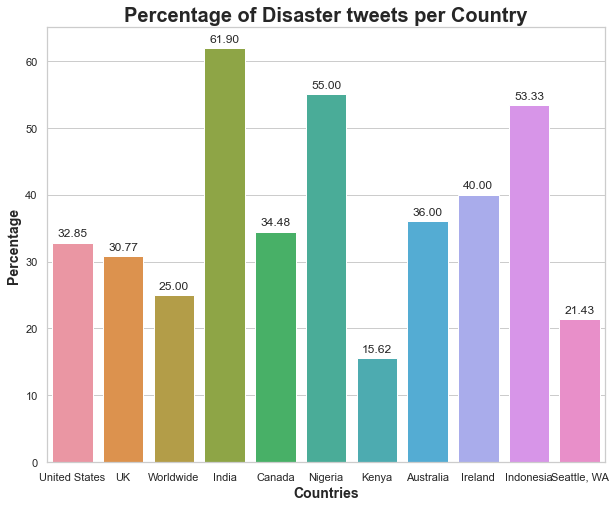

In [20]:
# creating new dataframe to replace the names we changed
df2 = full_df.copy()
df2["location"].replace(replace_names, inplace=True)

# count the number of disaster tweets in each location
country_disaster_tweets = df2[df2["location"].isin(countries_df.loc[:10, "country"])].groupby("location")["target"].sum()
country_disaster_tweets_df = pd.merge(left=countries_df, right=country_disaster_tweets, left_on="country", right_on="location")

# renaming target column
country_disaster_tweets_df.rename(columns={"target":"disaster_tweets"}, inplace=True)
country_disaster_tweets_df["percent_disaster_tweets"] = round(100 * country_disaster_tweets_df["disaster_tweets"]\
                                                              / country_disaster_tweets_df["unique_counts"], 2)

# plotting the percentages
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid", color_codes=True)
seaborn_plot = sns.barplot(x="country", y="percent_disaster_tweets", data=country_disaster_tweets_df)
for p in seaborn_plot.patches:
    seaborn_plot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center',
                   va = 'center', xytext = (0, 9), textcoords = 'offset points')
plt.title("Percentage of Disaster tweets per Country", size=20, weight="bold")
plt.xlabel("Countries", size=14, weight="bold")
plt.ylabel("Percentage", size=14, weight="bold")
plt.show()

### Duplicate Tweets

In [21]:
# all duplicate tweets
duplicated_df = full_df[full_df["text"].duplicated()]

print(f"Number of Duplicated Tweets in Train & Test: {len(duplicated_df)}\n\
Number of Duplicated Tweets in Train: {duplicated_df['target'].notna().sum()}\n\
Number of Duplicated Tweets in Test: {duplicated_df['target'].isna().sum()}\n")

Number of Duplicated Tweets in Train & Test: 198
Number of Duplicated Tweets in Train: 110
Number of Duplicated Tweets in Test: 88



In [22]:
# add all the tweets with duplicates
train_duplicates = train_df[train_df["text"].duplicated()].groupby(["text"])[["target"]].agg(list)

diff_label_idx = []
for idx, val in enumerate(train_duplicates["target"]):
    for ele in val: 
        if ele != val[0]:
            diff_label_idx.append(idx)
                
print(f"Number of Duplicated Tweets with different target labels in train: {len(diff_label_idx)}")

Number of Duplicated Tweets with different target labels in train: 12


In [23]:
# tweets with different labels
train_duplicates.iloc[diff_label_idx]

target
text                                                               
#Allah describes piling up #wealth thinking it ...           [0, 1]
#foodscare #offers2go #NestleIndia slips into l...           [1, 0]
.POTUS #StrategicPatience is a strategy for #Ge...        [1, 0, 1]
CLEARED:incident with injury:I-495  inner loop ...           [1, 0]
He came to a land which was engulfed in tribal ...  [1, 1, 0, 0, 0]
He came to a land which was engulfed in tribal ...  [1, 1, 0, 0, 0]
He came to a land which was engulfed in tribal ...  [1, 1, 0, 0, 0]
Hellfire is surrounded by desires so be careful...           [1, 0]
The Prophet (peace be upon him) said 'Save your...  [0, 1, 0, 0, 1]
The Prophet (peace be upon him) said 'Save your...  [0, 1, 0, 0, 1]
To fight bioterrorism sir.                                [0, 1, 0]
that horrible sinking feeling when youÛªve bee...        [0, 0, 1]

### Exploring Keywords

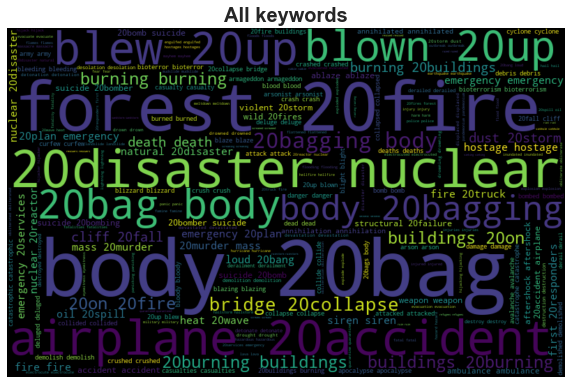

In [24]:
# getting all the keywords from keyword column
all_keywords = " ".join([keyword for keyword in full_df["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

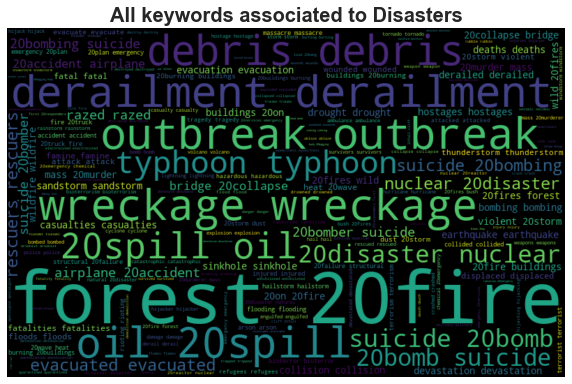

In [25]:
# all keywords from tweets associated to a disaster 
all_disaster_keywords = " ".join([keyword for keyword in full_df[full_df["target"]==1]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

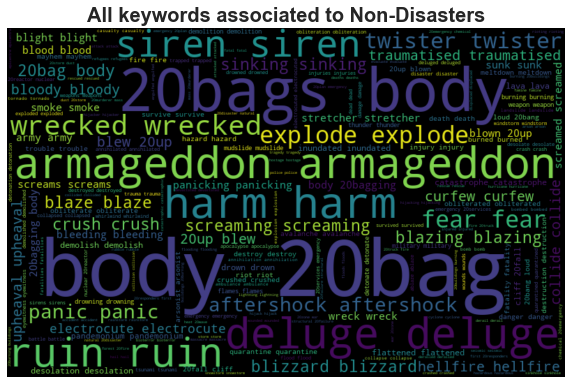

In [26]:
# all keywords from tweets NOT associated to disaster
all_non_disaster_keywords = " ".join([keyword for keyword in full_df[full_df["target"]==0]["keyword"].dropna()])

# visualizing keywords
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_keywords)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All keywords associated to Non-Disasters", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

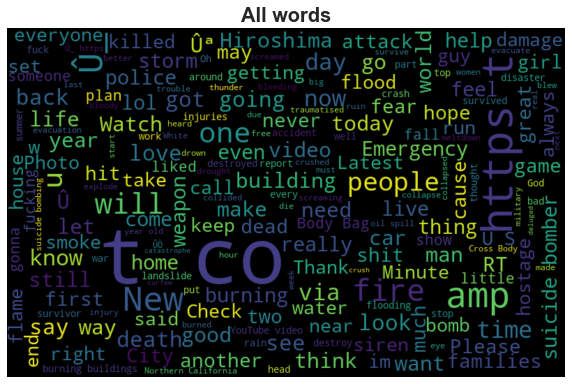

In [27]:
# keywords from our tweets 
all_tweets = " ".join([word for word in full_df["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

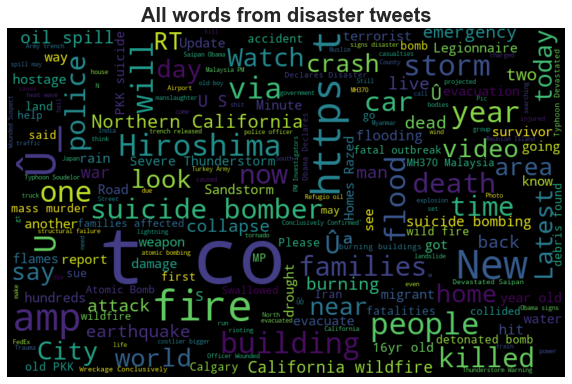

In [28]:
# keywords from our tweets associated to disasters
all_disaster_tweets = " ".join([word for word in full_df[full_df["target"]==1]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words from disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

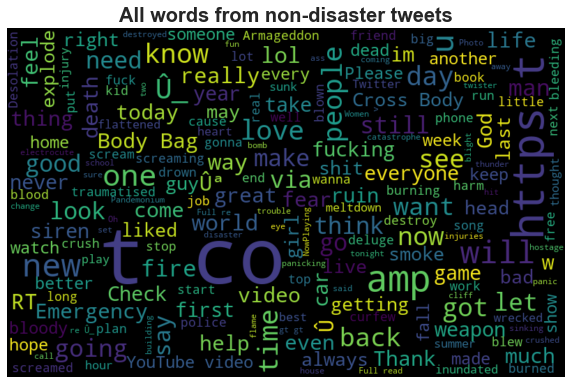

In [29]:
# keywords from our tweets associated to non-disasters
all_non_disaster_tweets = " ".join([word for word in full_df[full_df["target"]==0]["text"]])

# visualizing tweets
word_cloud= WordCloud(width=800,
                      height=500,
                      max_font_size=112,
                      random_state=24).generate(all_non_disaster_tweets)

# plotting 
plt.figure(figsize=(10, 8))
plt.title("All words from non-disaster tweets", size=20, weight="bold")
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [30]:
# keyword to target counts
keyword_count_df = pd.DataFrame(full_df.groupby(["keyword", "target"])["text"].count()).rename(columns={"text":"count"})
keyword_count_df.head(50)

count
keyword             target       
ablaze              0.0        23
                    1.0        13
accident            0.0        11
                    1.0        24
aftershock          0.0        34
airplane%20accident 0.0         5
                    1.0        30
ambulance           0.0        18
                    1.0        20
annihilated         0.0        23
                    1.0        11
annihilation        0.0        19
                    1.0        10
apocalypse          0.0        23
                    1.0         9
armageddon          0.0        37
                    1.0         5
army                0.0        29
                    1.0         5
arson               0.0        10
                    1.0        22
arsonist            0.0        26
                    1.0         8
attack              0.0        11
                    1.0        25
attacked            0.0        14
                    1.0        21
avalanche           0.0        26
                    1.0         4
battle              0.0        21
                    1.0         5
bioterror           0.0        15
                    1.0        22
bioterrorism        0.0         9
                    1.0        21
blaze               0.0        33
                    1.0         5
blazing             0.0        33
                    1.0         1
bleeding            0.0        30
                    1.0         5
blew%20up           0.0        31
                    1.0         2
blight              0.0        30
                    1.0         2
blizzard            0.0        33
                    1.0         4
blood               0.0        30
                    1.0         5
bloody              0.0        32

### Text Stats

In [31]:
# Code From https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

STOPWORDS = set(stopwords.words("english"))

# word_count
train_df['word_count'] = train_df['text'].apply(lambda x: len(str(x).split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))

# unique_word_count
train_df['unique_word_count'] = train_df['text'].apply(lambda x: len(set(str(x).split())))
test_df['unique_word_count'] = test_df['text'].apply(lambda x: len(set(str(x).split())))

# stop_word_count
train_df['stop_word_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))
test_df['stop_word_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if w in STOPWORDS]))

# url_count
train_df['url_count'] = train_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
test_df['url_count'] = test_df['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))

# mean_word_length
train_df['mean_word_length'] = train_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df['mean_word_length'] = test_df['text'].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

# char_count
train_df['char_count'] = train_df['text'].apply(lambda x: len(str(x)))
test_df['char_count'] = test_df['text'].apply(lambda x: len(str(x)))

# punctuation_count
train_df['punctuation_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['punctuation_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

# hashtag_count
train_df['hashtag_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
test_df['hashtag_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '#']))

# mention_count
train_df['mention_count'] = train_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
test_df['mention_count'] = test_df['text'].apply(lambda x: len([c for c in str(x) if c == '@']))

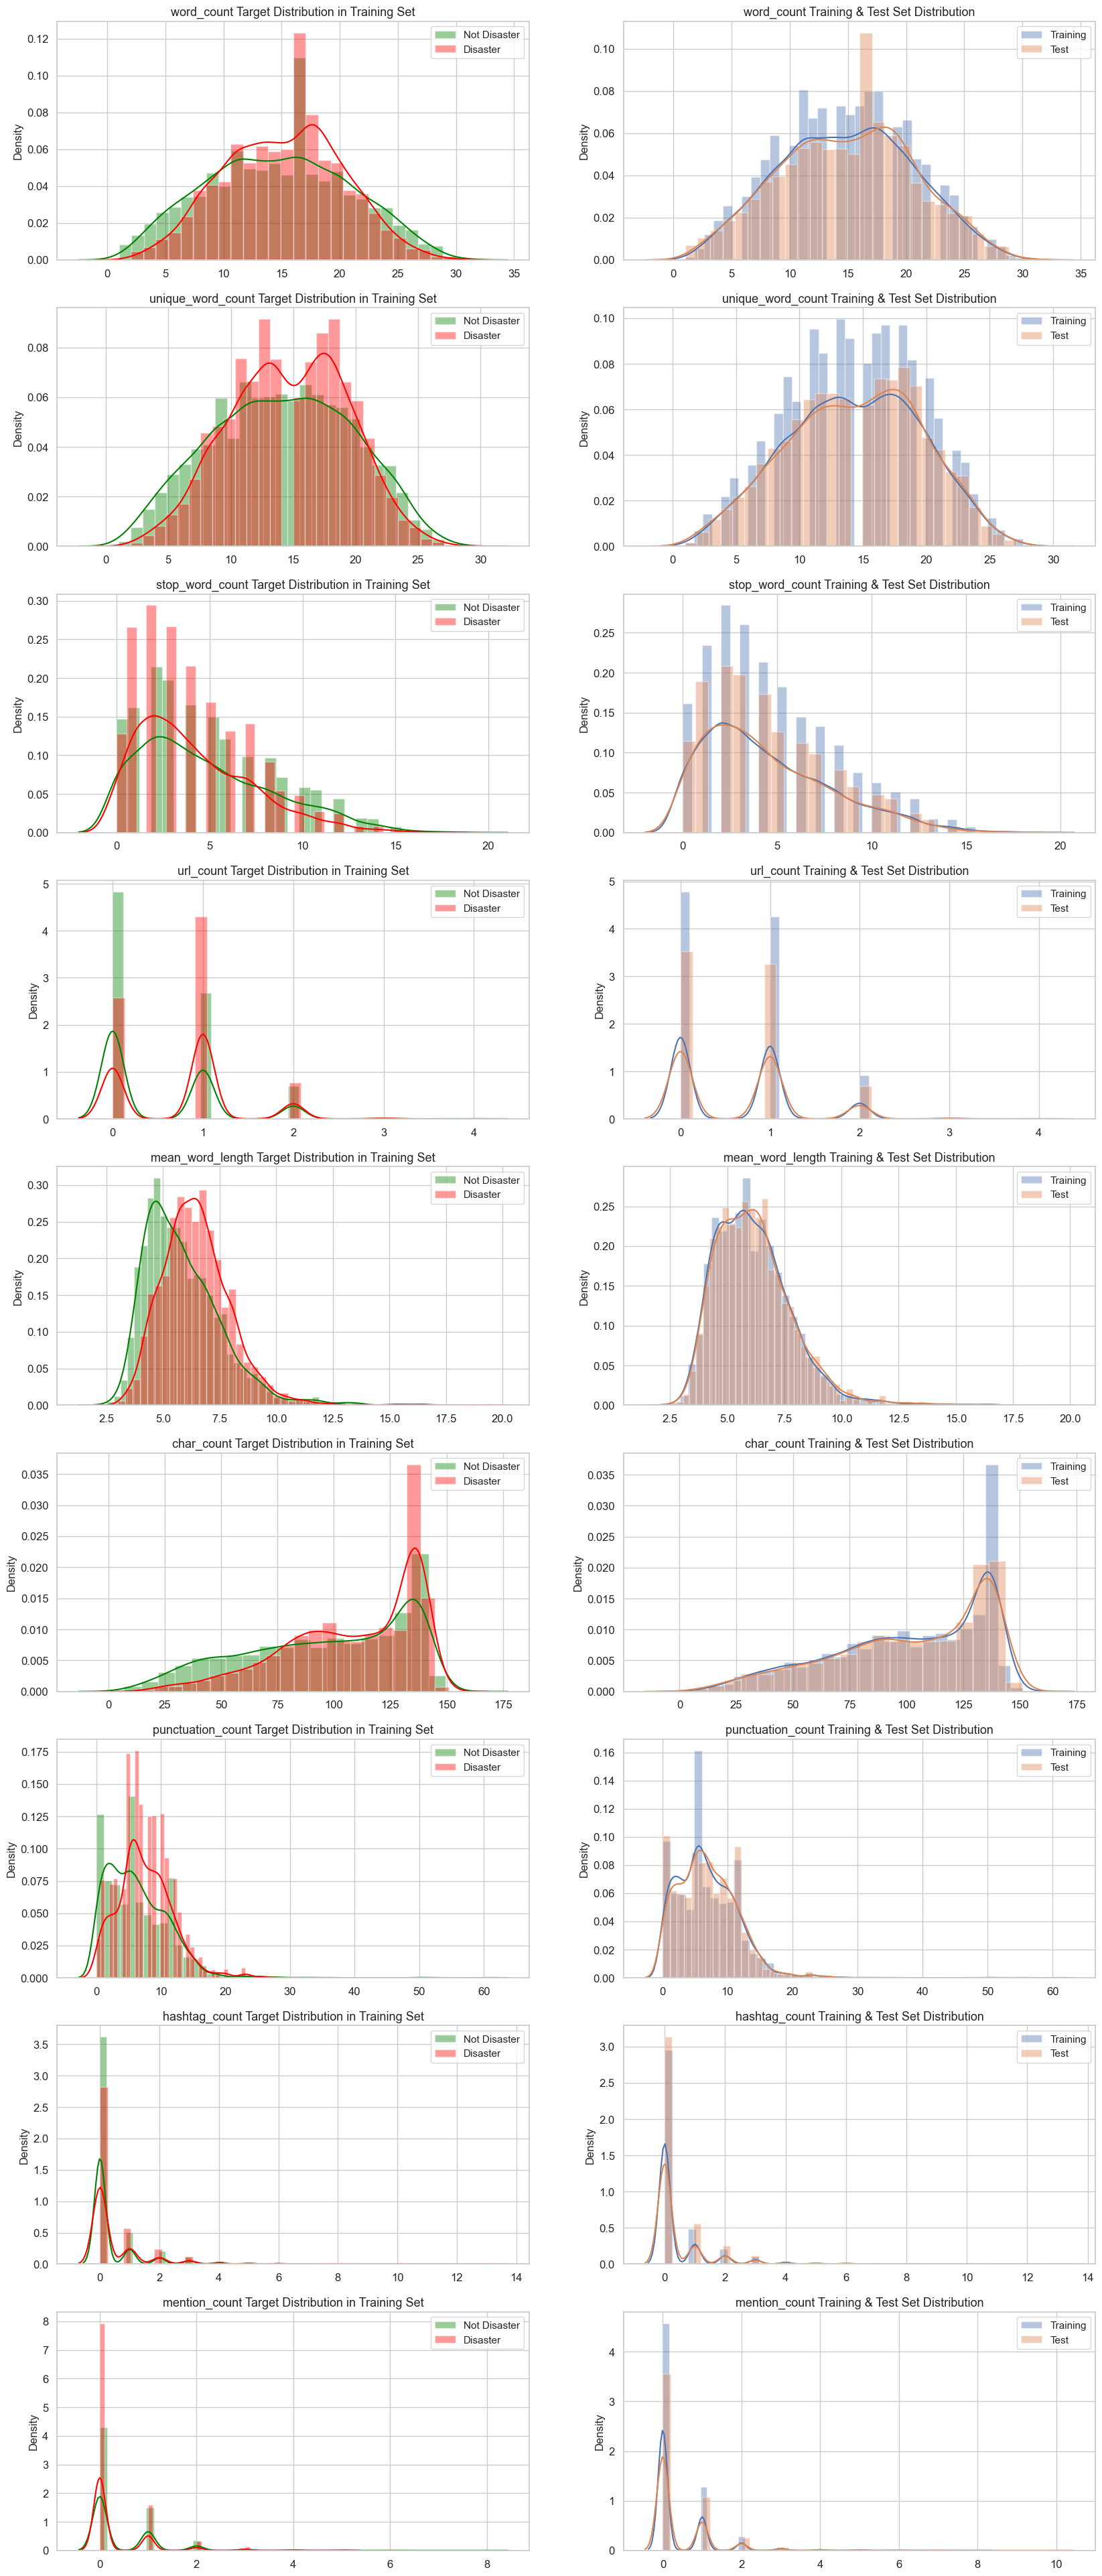

In [32]:
# Code From https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
METAFEATURES = ['word_count', 'unique_word_count', 'stop_word_count', 'url_count', 'mean_word_length',
                'char_count', 'punctuation_count', 'hashtag_count', 'mention_count']

DISASTER_TWEETS = train_df['target'] == 1

fig, axes = plt.subplots(ncols=2, nrows=len(METAFEATURES), figsize=(20, 50), dpi=100)

for i, feature in enumerate(METAFEATURES):
    sns.distplot(train_df.loc[~DISASTER_TWEETS][feature], label='Not Disaster', ax=axes[i][0], color='green')
    sns.distplot(train_df.loc[DISASTER_TWEETS][feature], label='Disaster', ax=axes[i][0], color='red')

    sns.distplot(train_df[feature], label='Training', ax=axes[i][1])
    sns.distplot(test_df[feature], label='Test', ax=axes[i][1])
    
    for j in range(2):
        axes[i][j].set_xlabel('')
        axes[i][j].tick_params(axis='x', labelsize=12)
        axes[i][j].tick_params(axis='y', labelsize=12)
        axes[i][j].legend()
    
    axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
    axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

plt.show()

# Preprocessing & Transformations

In [33]:
# function to clean tweets
def clean_tweet(tweet:str) -> str:
    """
    Convert all text to lowercase, remove stock market tickers, RT symbol, hyperlinks and the hastag symbol
    :param tweet: tweet by a unique user
    :return: cleaned string without hashtags, emojis, and punctuation
    """
    # make text lower case
    tweet = tweet.lower()
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', str(tweet))
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', str(tweet))
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', str(tweet))
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', str(tweet))
    
    # remove punctuation
    punct = set(string.punctuation)
    tweet = "".join(ch for ch in tweet if ch not in punct)
    
    # remove stopwords
    stop_words = set(stopwords.words("english"))
    tweet = " ".join(word for word in tweet.split() if word not in stop_words)
    
    return tweet

def target_relabel(df:pd.DataFrame) -> pd.DataFrame:
    """
    Relabel duplicate tweets that are mislabelled in the training dataset
    :param df: A pandas dataframe with a "target" column
    :return: df
    """
    # manually relabel all mislabelled targets
    df.loc[df["text"]==
           "#Allah describes piling up #wealth thinking it would last #forever as the description of the people of #Hellfire in Surah Humaza. #Reflect",
           "target"]= 0
    df.loc[df["text"]==
          "#foodscare #offers2go #NestleIndia slips into loss after #Magginoodle #ban unsafe and hazardous for #humanconsumption",
          "target"] = 0
    df.loc[df["text"]==
          ".POTUS #StrategicPatience is a strategy for #Genocide; refugees; IDP Internally displaced people; horror; etc. https://t.co/rqWuoy1fm4",
          "target"] = 0
    df.loc[df["text"]==
          "CLEARED:incident with injury:I-495  inner loop Exit 31 - MD 97/Georgia Ave Silver Spring",
          "target"] = 1
    df.loc[df["text"]==
          "He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam",
          "target"] = 0
    df.loc[df["text"]==
          "Hellfire is surrounded by desires so be careful and donÛªt let your desires control you! #Afterlife",
          "target"] = 0
    df.loc[df["text"]==
          "The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'",
          "target"] = 0
    df.loc[df["text"]=="To fight bioterrorism sir.", "target"] = 0
    df.loc[df["text"]==
          "that horrible sinking feeling when youÛªve been at home on your phone for a while and you realise its been on 3G this whole time",
          "target"] = 0
    return df

In [34]:
# seperate off train and test
train = full_df.iloc[:len(train_df), :]
test = full_df.iloc[len(train_df):, :]

In [35]:
# clean tweets
train["text_clean"] = train["text"].apply(clean_tweet)
test["text_clean"] = test["text"].apply(clean_tweet)
train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target                                         text_clean  
0     1.0       deeds reason earthquake may allah forgive us  
1     1.0              forest fire near la ronge sask canada  
2     1.0  residents asked shelter place notified officer...  
3     1.0  13000 people receive wildfires evacuation orde...  
4     1.0  got sent photo ruby alaska smoke wildfires pou...

In [36]:
# relabel targets in train
train_df = target_relabel(train_df)

# checking if old different labels are now all the same
train_diff_label = train_duplicates.iloc[diff_label_idx].index
# will generate new example after each run
train_df.loc[train_df["text"] == train_diff_label[np.random.randint(0, len(train_diff_label))], ["text", "target"]]

text  target
2830  .POTUS #StrategicPatience is a strategy for #G...       0
2831  .POTUS #StrategicPatience is a strategy for #G...       0
2832  .POTUS #StrategicPatience is a strategy for #G...       0
2833  .POTUS #StrategicPatience is a strategy for #G...       0

In [37]:
# target variable 
y = train["target"].values

# initializing Kfold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=24)

# count vectorizer transformation
count_vect = CountVectorizer()
count_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_count_vect = count_vect.transform(train["text_clean"])

# tfidf vectorizer transformation 
tfidf_vect = TfidfVectorizer()
tfidf_vect.fit(train["text_clean"].values.tolist() + test["text_clean"].values.tolist())
train_tfidf_vect = tfidf_vect.transform(train["text_clean"])

# Classification

In [38]:
# models
models= {
    "svm": SVC(),
    "logistic_regression": LogisticRegression(),
    "naive_bayes": MultinomialNB(),
    "SGD": SGDClassifier(),
    "random_forest": RandomForestClassifier()
}

# current vectors
vectors = {
    "count_vect": train_count_vect,
    "tfidf_vect": train_tfidf_vect
}

In [39]:
def stratified_kfold(clf:str, vect_type:str, y, kfold):
    """
    Perform Kfold Cross-Validation
    :param model: the model used to make predictions
    :param X: the train features being used 
    :param y: the target feature,
    :param kfold: the cross validation strategy
    :return: dictionary with model name key and results as the values
    """
    results = {}
    # store the name of the model in dictionary
    results["model_name"] = clf + "_" + vect_type
    
    # call the model and training data
    model = models[clf]
    X = vectors[vect_type]
    
    # perfrom kfold cv
    for fold, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
        X_train, X_valid = X[train_idx], X[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        # train on seen data, predict on unseen
        model.fit(X_train, y_train)
        y_preds = model.predict(X_valid)
        
        results["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)
    return results

In [40]:
# store all models
all_models = []

for clf in models:
    for vect in vectors:
        all_models.append(stratified_kfold(clf, vect, y, skf))
        print(f"Current Model: {clf}_{vect}...\n")

Current Model: svm_count_vect...

Current Model: svm_tfidf_vect...

Current Model: logistic_regression_count_vect...

Current Model: logistic_regression_tfidf_vect...

Current Model: naive_bayes_count_vect...

Current Model: naive_bayes_tfidf_vect...

Current Model: SGD_count_vect...

Current Model: SGD_tfidf_vect...

Current Model: random_forest_count_vect...

Current Model: random_forest_tfidf_vect...



In [41]:
# convert to df
models_df = pd.DataFrame(all_models)
models_df

model_name    fold_1    fold_2    fold_3    fold_4  \
0                  svm_count_vect  0.726481  0.727915  0.747116  0.748252   
1                  svm_tfidf_vect  0.711312  0.702304  0.718750  0.724138   
2  logistic_regression_count_vect  0.737531  0.735802  0.750422  0.742998   
3  logistic_regression_tfidf_vect  0.735371  0.713781  0.736748  0.738707   
4          naive_bayes_count_vect  0.753165  0.736508  0.753036  0.755842   
5          naive_bayes_tfidf_vect  0.737747  0.703030  0.739629  0.739774   
6                  SGD_count_vect  0.725567  0.713154  0.735818  0.724638   
7                  SGD_tfidf_vect  0.734930  0.727569  0.754371  0.744186   
8        random_forest_count_vect  0.727578  0.726968  0.748528  0.731747   
9        random_forest_tfidf_vect  0.712702  0.710169  0.739655  0.733837   

     fold_5  
0  0.725835  
1  0.698994  
2  0.750000  
3  0.723063  
4  0.741281  
5  0.720070  
6  0.711726  
7  0.738513  
8  0.715736  
9  0.711835

#### LightGBM 

In [42]:
# light gbm parameters
lgbm_params = {
    "learning_rate": 0.02, 
    "random_state": 24, 
    "metric": "auc",
    "n_estimators": 2000
}

In [43]:
# train then validate lightgbm with count vectors
model_dict = {}
model_dict["model_name"] = "lgbm_count_vect"

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_count_vect, y)):
    print(f"\nCurrently Training: {model_dict['model_name']}... Fold: {fold+1}")
    X_train, X_valid= train_count_vect[train_idx].astype(np.float32), train_count_vect[valid_idx].astype(np.float32)
    y_train, y_valid= y[train_idx].astype(np.float32), y[valid_idx].astype(np.float32)

    # training
    lgbm = lgb.LGBMClassifier(**lgbm_params)
    lgbm.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)

    # predictions
    y_preds = lgbm.predict(X_valid)
    model_dict["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)


# adding results to models df
new_model = pd.DataFrame(model_dict, columns=models_df.columns, index=[0])
models_df = pd.concat([models_df, new_model], ignore_index=True)


Currently Training: lgbm_count_vect... Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.805416
[200]	valid_0's auc: 0.825222
[300]	valid_0's auc: 0.83141
[400]	valid_0's auc: 0.833187
[500]	valid_0's auc: 0.833978
[600]	valid_0's auc: 0.834552
[700]	valid_0's auc: 0.835404
Early stopping, best iteration is:
[622]	valid_0's auc: 0.835658

Currently Training: lgbm_count_vect... Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.815301
[200]	valid_0's auc: 0.830552
[300]	valid_0's auc: 0.830014
Early stopping, best iteration is:
[213]	valid_0's auc: 0.831145

Currently Training: lgbm_count_vect... Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.823354
[200]	valid_0's auc: 0.843054
[300]	valid_0's auc: 0.850541
[400]	valid_0's auc: 0.850172
Early stopping, best iteration is:
[313]	valid_0's auc: 0.850938

Currently Training: lgbm_count_vect... Fold: 4
Training

In [44]:
# train then validate lightgbm with tfidf vectors
model_dict = {}
model_dict["model_name"] = "lgbm_tfidf_vect"

for fold, (train_idx, valid_idx) in enumerate(skf.split(train_tfidf_vect, y)):
    print(f"\nCurrently Training: {model_dict['model_name']}... Fold: {fold+1}")
    X_train, X_valid= train_tfidf_vect[train_idx].astype(np.float32), train_tfidf_vect[valid_idx].astype(np.float32)
    y_train, y_valid= y[train_idx].astype(np.float32), y[valid_idx].astype(np.float32)

    # training
    lgbm = lgb.LGBMClassifier(**lgbm_params)
    lgbm.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)

    # predictions
    y_preds = lgbm.predict(X_valid)
    model_dict["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)

# adding results to models df
new_model = pd.DataFrame(model_dict, columns=models_df.columns, index=[0])
models_df = pd.concat([models_df, new_model], ignore_index=True)


Currently Training: lgbm_tfidf_vect... Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.802061
[200]	valid_0's auc: 0.824537
[300]	valid_0's auc: 0.829379
[400]	valid_0's auc: 0.829765
Early stopping, best iteration is:
[316]	valid_0's auc: 0.830546

Currently Training: lgbm_tfidf_vect... Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.806633
[200]	valid_0's auc: 0.82151
[300]	valid_0's auc: 0.825436
[400]	valid_0's auc: 0.824272
Early stopping, best iteration is:
[314]	valid_0's auc: 0.826033

Currently Training: lgbm_tfidf_vect... Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.818616
[200]	valid_0's auc: 0.834182
[300]	valid_0's auc: 0.840385
[400]	valid_0's auc: 0.841885
Early stopping, best iteration is:
[392]	valid_0's auc: 0.842282

Currently Training: lgbm_tfidf_vect... Fold: 4
Training until validation scores don't improve for 100 rounds
[100]	

In [45]:
models_df["avg"] = 100*(models_df.loc[:, "fold_1":"fold_5"].sum(axis=1)/5)
models_df

model_name    fold_1    fold_2    fold_3    fold_4  \
0                   svm_count_vect  0.726481  0.727915  0.747116  0.748252   
1                   svm_tfidf_vect  0.711312  0.702304  0.718750  0.724138   
2   logistic_regression_count_vect  0.737531  0.735802  0.750422  0.742998   
3   logistic_regression_tfidf_vect  0.735371  0.713781  0.736748  0.738707   
4           naive_bayes_count_vect  0.753165  0.736508  0.753036  0.755842   
5           naive_bayes_tfidf_vect  0.737747  0.703030  0.739629  0.739774   
6                   SGD_count_vect  0.725567  0.713154  0.735818  0.724638   
7                   SGD_tfidf_vect  0.734930  0.727569  0.754371  0.744186   
8         random_forest_count_vect  0.727578  0.726968  0.748528  0.731747   
9         random_forest_tfidf_vect  0.712702  0.710169  0.739655  0.733837   
10                 lgbm_count_vect  0.720528  0.682310  0.719586  0.717735   
11                 lgbm_tfidf_vect  0.695427  0.687225  0.721368  0.711489   

      fold_5        avg  
0   0.725835  73.511976  
1   0.698994  71.109958  
2   0.750000  74.335061  
3   0.723063  72.953393  
4   0.741281  74.796648  
5   0.720070  72.805019  
6   0.711726  72.218062  
7   0.738513  73.991390  
8   0.715736  73.011145  
9   0.711835  72.163992  
10  0.711617  71.035515  
11  0.695580  70.221766

#### Word2Vec Embeddings

In [38]:
def get_word2vec_enc(corpus:list, vocab_size:int, embedding_size:int, gensim_pretrained_emb:str) -> list:
    """
    Get the embeddings value for each word withing
    :param corpus: The text we want to get embeddings for
    :param vocab_list: The size of the vocabulary
    :param embedding_size: The dimensions of the embedding
    :param gensim_pretrained_emb: The pretrained embedding from gensim
    :return: words encoded as vectors
    """
    word_vecs = api.load(gensim_pretrained_emb)
    embedding_weights = np.zeros((vocab_size, embedding_size))
    for word, i in corpus:
        if word in word_vecs:
            embedding_weights[i] = word_vecs[word]
    return embedding_weights

In [39]:
# lstm configurations
n_epochs = 8
embedding_size = 300
max_length = 202
pretrained_embedding_file = "word2vec-google-news-300"

# tokenizer
tokenizer = Tokenizer(oov_token="<unk>")
tokenizer.fit_on_texts(train["text_clean"].values)
train_tokenized_list = tokenizer.texts_to_sequences(train["text_clean"].values)

# store vocab size 
vocab_size = len(tokenizer.word_index) + 1

# padding sequences
X_padded = pad_sequences(train_tokenized_list, maxlen=max_length)

# get the pretrained word embeddings and prepare embedding layer
embedding_matrix = get_word2vec_enc(corpus=tokenizer.word_index.items(),
                                    vocab_size=vocab_size,
                                    embedding_size=embedding_size,
                                    gensim_pretrained_emb=pretrained_embedding_file)

embedding_layer = Embedding(input_dim=vocab_size,
                            output_dim=embedding_size,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

#### LSTM

In [40]:
def my_LSTM(embedding_layer):
    print('Creating model...')
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
    model.add(Dense(50, activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))

    print('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

In [49]:
# stratified kfold with LSTM 
model_dict = {}
model_dict["model_name"] = "lstm_word_2_vec"

for fold, (train_idx, val_idx) in enumerate(skf.split(X=X_padded, y=y)):
    print(f"\nCurrently Training: {model_dict['model_name']}... Fold: {fold+1}")
    X_train, X_val = X_padded[train_idx], X_padded[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
     
    # train the model
    clf = my_LSTM(embedding_layer)
    clf.fit(X_train,
            y_train,
            epochs=n_epochs,
            verbose=1)
    # make predictions
    y_preds = clf.predict_classes(X_val, verbose=-1)
    model_dict["fold_{}".format(fold+1)] = f1_score(y_val, y_preds)
        
# adding results to models df
new_model = pd.DataFrame(model_dict, columns=models_df.columns, index=[0])
models_df = pd.concat([models_df, new_model], ignore_index=True)


Currently Training: lstm_word_2_vec... Fold: 1
Creating model...
Compiling...
Epoch 1/8
191/191 [==============================] - 78s 385ms/step - loss: 0.5551 - accuracy: 0.7294
Epoch 2/8
191/191 [==============================] - 76s 397ms/step - loss: 0.4382 - accuracy: 0.8062
Epoch 3/8
191/191 [==============================] - 76s 397ms/step - loss: 0.4022 - accuracy: 0.8288
Epoch 4/8
191/191 [==============================] - 76s 395ms/step - loss: 0.3937 - accuracy: 0.8351
Epoch 5/8
191/191 [==============================] - 76s 396ms/step - loss: 0.3717 - accuracy: 0.8451
Epoch 6/8
191/191 [==============================] - 76s 396ms/step - loss: 0.3506 - accuracy: 0.8575
Epoch 7/8
191/191 [==============================] - 77s 402ms/step - loss: 0.3267 - accuracy: 0.8648
Epoch 8/8
191/191 [==============================] - 77s 402ms/step - loss: 0.3089 - accuracy: 0.8734

Currently Training: lstm_word_2_vec... Fold: 2
Creating model...
Compiling...
Epoch 1/8
191/191 [=======

In [50]:
# train then validate lightgbm with word2vec vectors
model_dict = {}
model_dict["model_name"] = "lgbm_word_2_vec"

for fold, (train_idx, valid_idx) in enumerate(skf.split(X_padded, y)):
    print(f"\nCurrently Training: {model_dict['model_name']}... Fold: {fold+1}")
    X_train, X_valid= X_padded[train_idx].astype(np.float32), X_padded[valid_idx].astype(np.float32)
    y_train, y_valid= y[train_idx].astype(np.float32), y[valid_idx].astype(np.float32)

    # training
    lgbm = lgb.LGBMClassifier(**lgbm_params)
    lgbm.fit(X_train,
             y_train,
             eval_set=[(X_valid, y_valid)],
             verbose=100,
             early_stopping_rounds=100)

    # predictions
    y_preds = lgbm.predict(X_valid)
    model_dict["fold_{}".format(fold+1)] = f1_score(y_valid, y_preds)

# adding results to models df
new_model = pd.DataFrame(model_dict, columns=models_df.columns, index=[0])
models_df = pd.concat([models_df, new_model], ignore_index=True)


Currently Training: lgbm_word_2_vec... Fold: 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.682487
[200]	valid_0's auc: 0.691179
[300]	valid_0's auc: 0.69598
[400]	valid_0's auc: 0.698711
[500]	valid_0's auc: 0.698148
Early stopping, best iteration is:
[446]	valid_0's auc: 0.699143

Currently Training: lgbm_word_2_vec... Fold: 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.652833
[200]	valid_0's auc: 0.662344
[300]	valid_0's auc: 0.669086
[400]	valid_0's auc: 0.673721
[500]	valid_0's auc: 0.673499
Early stopping, best iteration is:
[400]	valid_0's auc: 0.673721

Currently Training: lgbm_word_2_vec... Fold: 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's auc: 0.695932
[200]	valid_0's auc: 0.708832
[300]	valid_0's auc: 0.715208
[400]	valid_0's auc: 0.716586
Early stopping, best iteration is:
[376]	valid_0's auc: 0.717966

Currently Training: lgbm_word_2_vec... Fold: 4
Training

In [51]:
models_df["avg"] = 100*(models_df.loc[:, "fold_1":"fold_5"].sum(axis=1)/5)
models_df

model_name    fold_1    fold_2    fold_3    fold_4  \
0                   svm_count_vect  0.726481  0.727915  0.747116  0.748252   
1                   svm_tfidf_vect  0.711312  0.702304  0.718750  0.724138   
2   logistic_regression_count_vect  0.737531  0.735802  0.750422  0.742998   
3   logistic_regression_tfidf_vect  0.735371  0.713781  0.736748  0.738707   
4           naive_bayes_count_vect  0.753165  0.736508  0.753036  0.755842   
5           naive_bayes_tfidf_vect  0.737747  0.703030  0.739629  0.739774   
6                   SGD_count_vect  0.725567  0.713154  0.735818  0.724638   
7                   SGD_tfidf_vect  0.734930  0.727569  0.754371  0.744186   
8         random_forest_count_vect  0.727578  0.726968  0.748528  0.731747   
9         random_forest_tfidf_vect  0.712702  0.710169  0.739655  0.733837   
10                 lgbm_count_vect  0.720528  0.682310  0.719586  0.717735   
11                 lgbm_tfidf_vect  0.695427  0.687225  0.721368  0.711489   
12                 lstm_word_2_vec  0.752506  0.735000  0.749565  0.759839   
13                 lgbm_word_2_vec  0.564236  0.520354  0.551978  0.534283   

      fold_5        avg  
0   0.725835  73.511976  
1   0.698994  71.109958  
2   0.750000  74.335061  
3   0.723063  72.953393  
4   0.741281  74.796648  
5   0.720070  72.805019  
6   0.711726  72.218062  
7   0.738513  73.991390  
8   0.715736  73.011145  
9   0.711835  72.163992  
10  0.711617  71.035515  
11  0.695580  70.221766  
12  0.755880  75.055806  
13  0.547515  54.367329

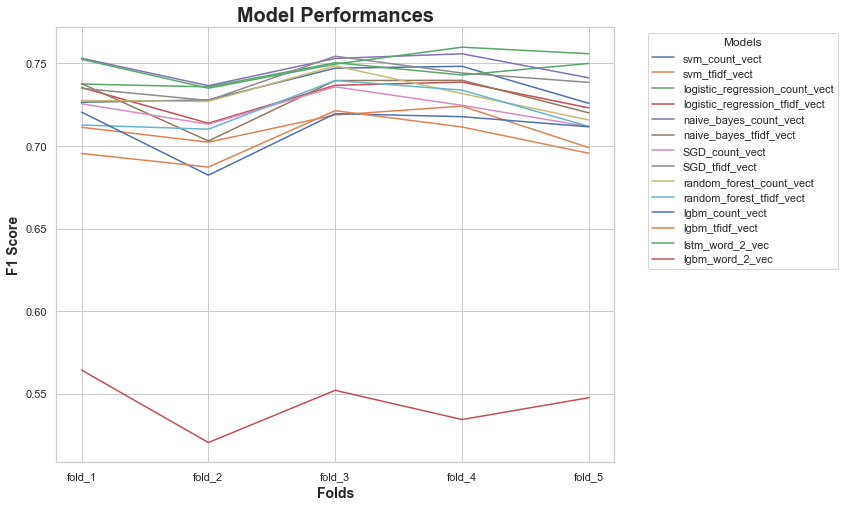

In [53]:
# transposing the dataframe
model_names = models_df["model_name"].values
model_names_mappings = dict(zip(range(0, len(model_names)), model_names))
transpose_models_df = models_df.loc[:, "fold_1":"fold_5"].T.rename(columns=model_names_mappings)

x = transpose_models_df.index
fig, ax = plt.subplots(figsize=(10,8))

for model in transpose_models_df.columns:
    plt.plot(x, transpose_models_df[model], label=model)
plt.title("Model Performances", size=20, weight="bold")
plt.xlabel("Folds", size=14, weight="bold")
plt.ylabel("F1 Score", size=14, weight="bold")
plt.legend(title="Models", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

# Evaluation

In [47]:
# training a single LSTM model
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=.3, shuffle=True, random_state=24)

clf = my_LSTM(embedding_layer)
clf.fit(X_train,
        y_train,
        epochs=n_epochs,
        verbose=1)

# make predictions
y_preds = clf.predict_classes(X_valid, verbose=-1)
y_train_preds = clf.predict_classes(X_train, verbose=-1)

print(f"\n\nTrain F1 Score: {f1_score(y_train ,y_train_preds)}\nValid F1 Score: {f1_score(y_valid ,y_preds)}")

Creating model...
Compiling...
Epoch 1/8
167/167 [==============================] - 82s 463ms/step - loss: 0.5679 - accuracy: 0.7120
Epoch 2/8
167/167 [==============================] - 78s 470ms/step - loss: 0.4423 - accuracy: 0.8095
Epoch 3/8
167/167 [==============================] - 82s 489ms/step - loss: 0.4185 - accuracy: 0.8195
Epoch 4/8
167/167 [==============================] - 83s 497ms/step - loss: 0.3843 - accuracy: 0.8404
Epoch 5/8
167/167 [==============================] - 83s 497ms/step - loss: 0.3576 - accuracy: 0.8475
Epoch 6/8
167/167 [==============================] - 83s 496ms/step - loss: 0.3375 - accuracy: 0.8602
Epoch 7/8
167/167 [==============================] - 87s 523ms/step - loss: 0.3247 - accuracy: 0.8629
Epoch 8/8
167/167 [==============================] - 88s 526ms/step - loss: 0.2990 - accuracy: 0.8753


Train F1 Score: 0.8829623098964073
Valid F1 Score: 0.76232308443143


In [48]:
# printing the report
print(classification_report(y_valid, y_preds))

              precision    recall  f1-score   support

         0.0       0.81      0.80      0.81      1272
         1.0       0.75      0.77      0.76      1012

    accuracy                           0.79      2284
   macro avg       0.78      0.79      0.78      2284
weighted avg       0.79      0.79      0.79      2284



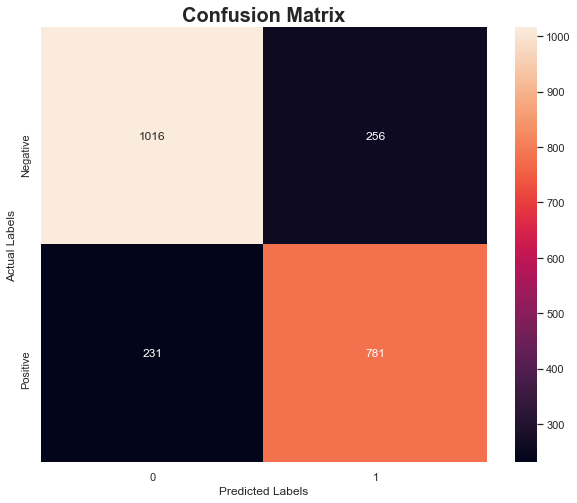

In [49]:
# plotting confusion matrix
labels= ["Negative", "Positive"]
cm = confusion_matrix(y_valid, y_preds)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="g", ax=ax)
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix", size=20, weight="bold")
plt.yticks(ticks=[0.5, 1.5], labels=labels)
plt.show()

# Overcoming Overfitting

### Removing a Layer

In [50]:
def my_LSTM(embedding_layer):
    print('Creating model...')
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))

    print('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

# training a single LSTM model
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=.3, shuffle=True, random_state=24)

# initializing model
clf = my_LSTM(embedding_layer)
print(clf.summary())

# training the model
clf.fit(X_train,
        y_train,
        epochs=n_epochs,
        verbose=1)

# make predictions
y_preds = clf.predict_classes(X_valid, verbose=-1)
y_train_preds = clf.predict_classes(X_train, verbose=-1)

print(f"\n\nTrain F1 Score: {f1_score(y_train ,y_train_preds)}\nValid F1 Score: {f1_score(y_valid ,y_preds)}")

Creating model...
Compiling...
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 202, 300)          5187000   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 129       
Total params: 5,374,009
Trainable params: 187,009
Non-trainable params: 5,187,000
_________________________________________________________________
None
Epoch 1/8
167/167 [==============================] - 82s 466ms/step - loss: 0.5715 - accuracy: 0.7045
Epoch 2/8
167/167 [==============================] - 77s 458ms/step - loss: 0.4393 - accuracy: 0.8

### Adding L2 Normalization

In [52]:
def my_LSTM(embedding_layer):
    print('Creating model...')
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))

    print('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

# training a single LSTM model
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=.3, shuffle=True, random_state=24)

# initializing model
clf = my_LSTM(embedding_layer)
print(clf.summary())

# training model
clf.fit(X_train,
        y_train,
        epochs=n_epochs,
        verbose=1)

# make predictions
y_preds = clf.predict_classes(X_valid, verbose=-1)
y_train_preds = clf.predict_classes(X_train, verbose=-1)

print(f"\n\nTrain F1 Score: {f1_score(y_train ,y_train_preds)}\nValid F1 Score: {f1_score(y_valid ,y_preds)}")

Creating model...
Compiling...
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 202, 300)          5187000   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_7 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total params: 5,380,381
Trainable params: 193,381
Non-trainable params: 5,187,000
_________________________________________________________________
None
Epoch 1/8
167/167 [==============================] - 90s 510ms/step 

### Adding Dropout Layers

In [53]:
def my_LSTM(embedding_layer):
    print('Creating model...')
    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))

    print('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

# training a single LSTM model
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=.3, shuffle=True, random_state=24)

# initializing model
clf = my_LSTM(embedding_layer)
print(clf.summary())

# training model
clf.fit(X_train,
        y_train,
        epochs=n_epochs,
        verbose=1)

# make predictions
y_preds = clf.predict_classes(X_valid, verbose=-1)
y_train_preds = clf.predict_classes(X_train, verbose=-1)

print(f"\n\nTrain F1 Score: {f1_score(y_train ,y_train_preds)}\nValid F1 Score: {f1_score(y_valid ,y_preds)}")

Creating model...
Compiling...
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 202, 300)          5187000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 202, 300)          0         
_________________________________________________________________
bidirectional_6 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_9 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
Total params: 5,380,381
Trainable params: 193,381
Non-trainable params: 5,187,000
_______

### Early Stopping

In [43]:
def my_LSTM(embedding_layer):
    print('Creating model...')
    model = Sequential()
    model.add(embedding_layer)
    model.add(Bidirectional(LSTM(units=64, dropout=0.1,  recurrent_dropout=0.1)))
    model.add(Dense(50, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
    model.add(Dropout(0.1))
    model.add(Dense(1, activation = "sigmoid"))

    print('Compiling...')
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=["accuracy"])
    return model

# training a single LSTM model
X_train, X_valid, y_train, y_valid = train_test_split(X_padded, y, test_size=.3, shuffle=True, random_state=24)

# initializing model
clf = my_LSTM(embedding_layer)
print(clf.summary())

# initializing early stopping 
early_stopping = EarlyStopping(monitor='loss', patience=3)

# training model
clf.fit(X_train,
        y_train,
        epochs=n_epochs,
        callbacks=[early_stopping],
        verbose=1)

# make predictions
y_preds = clf.predict_classes(X_valid, verbose=-1)
y_train_preds = clf.predict_classes(X_train, verbose=-1)

print(f"\n\nTrain F1 Score: {f1_score(y_train ,y_train_preds)}\nValid F1 Score: {f1_score(y_valid ,y_preds)}")

Creating model...
Compiling...
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 202, 300)          5187000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_4 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 5,380,381
Trainable params: 193,381
Non-trainable params: 5,187,000
_________________________________________________________________
None
Epoch 1/8
167/167 [==============================] - 85s 482ms/step 